# Char2vec

In [1]:
from bs4 import BeautifulSoup
import os
import codecs

from sklearn.manifold import TSNE
from matplotlib import pylab

import collections
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import re
%matplotlib inline

### Configuration

In [2]:
batch_size = 20# 20
embedding_size = 10
num_sampled = 15

In [3]:
# Leaf_information.py -> convt_1d_arr function
# 다른점: .join(str(x) for x in content) -> .join((x) for x in content) 
def convt_1d_arr(old_list): 
    
    # 문제점: class 속성값들이 항상 string이 아닌 list값을 가지고, 심지어 띄어쓰기가 있을 경우 각각 나눠서 element로 잡는다. 
    # class를 제외한 다른 태그속성들은 그렇지 않다.
    
    ## Step1: [['ab','c'], 'def'] -> [['ab c'], ['def']] (띄어쓰기를 살려둔채 하나로 묶는다.)
    for idx, content in enumerate(old_list):
        if type(content)==type([]):
            if len(content)>=2: 
                temp = " ".join((x) for x in content) # " " 쉼표를 연결점으로 합체
                old_list[idx] = [] # 초기화 하고 (비워놓고)
                old_list[idx].append(temp) # [u'story', u'story-body__h2'] -> ['story body__h1'] 할당
    
    ## Step2: [['abc'], 'def'] or ['abc', ['def']] -> ['abc', 'def']
    new_list = []
    for i in old_list:
        if type(i)==type([]): 
            new_list.insert(0, i[0]) # Step1을 거쳤기 때문에 하나의 element만 가지는 array가 존재하므로 그냥 i[0] 할당, 그리고 class 속성이므로 맨 앞자리로 할당
        else: new_list.append(i)
    
    return new_list

### Load data and make 1d word list

In [4]:
global all_tag_attrs_list
all_tag_attrs_list = []

# http://pythoncentral.io/how-to-traverse-a-directory-tree-in-python-guide-to-os-walk/
#dataset_path = './article_dataset'
dataset_path = './original_dataset'
#dataset_path = './test_dataset'

# 이중 폴더 속에 있는 파일들을 Load하기 위한 이중 for문
for dirName, subdirList, fileList in os.walk(dataset_path):
    #print('Found directory: %s' % dirName)
    for fname in fileList:
        
        # 파일의 절대 경로를 만들어 주기 위한 코드
        file_path = dirName+'/'+fname # ex: ./test_dataset/Telegraph/Google-2010-Telegraph-20160706164841234.html
        temp_str = dirName.split('/')
        publisher = temp_str[-1] # 현재 publisher 폴더이름
        
        ### a single html file load & preprocessing
        html_file = codecs.open(file_path, 'r')
        soup = BeautifulSoup(html_file, 'html.parser')
        for head in soup("head"): soup.head.extract()
        #soup = preprocessing(soup)
        
        
        
        ### same all tag names and tag attribute's contents
        for tag in soup.find_all(True):
        
        
            ### 태그 속성값 할당
            tag_attrs_list = convt_1d_arr(tag.attrs.values())    
            if(len(tag_attrs_list)!=0): # 속성내용이 없으면 pass       
                 for a_attr in tag_attrs_list:
                        if(len(a_attr)>=2):
                            if not ('/') in a_attr: 
                                if not (':') in a_attr: 
                                    if not ('.') in a_attr: 
                                        if not ('#') in a_attr: 
                                            if not (',') in a_attr: 
                                                if not ('%') in a_attr: 
                                                    if not ("'") in a_attr: 
                                                        if not ('"') in a_attr: 
                                                            if not ('(') in a_attr:
                                                                if not (')') in a_attr: all_tag_attrs_list.append(a_attr)

            ### 태그이름 할당
            if(len((tag.name))>=2):
                all_tag_attrs_list.append((tag.name)) # str이므로 append

len(all_tag_attrs_list)

648208

### Preprocessing

데이터가 ['w1', 'w2', 'w3', ... ] 이렇게 하나의 list로 들어오면 된다.

In [5]:
# for test
#all_tag_attrs_list = ['abc','bca','abc','ccc','aaa','bbb','abb','bcc','caa','aab']

# for test
#words = ['storyberry', '1iCecream','leMon','3orange', 'boy', 'house', 'smart_phone', 'dog', 'fineturing', 'June', 'king', 'queen', 'vote-', 'wait', 'exo','zoo' ]

In [6]:
words = all_tag_attrs_list
characters = []
words = [re.sub('[^0-9a-z_-]+',' ',x.lower()) for x in words]
for i in words: characters.append(list(i))
    
merged_chars = []
for i in characters: merged_chars.append(collections.Counter(i))

temp = merged_chars[0]
for i in merged_chars: merged_chars[0] += i

total_merged_chars_count = merged_chars[0]-temp
#total_chars = [' ','-','_','0','1','2','3','4','5','6','7','8','9','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']



In [7]:
total_merged_chars_count.most_common()

[(u'i', 539799),
 (u'e', 387788),
 (u'a', 359461),
 (u't', 354221),
 (u'n', 340250),
 (u'l', 317883),
 (u'o', 289429),
 (u'r', 268552),
 (u's', 262358),
 (u'd', 229027),
 (u'-', 224066),
 (u'p', 176502),
 (u'c', 171146),
 (u'v', 169791),
 (u'm', 149088),
 (u'_', 127612),
 (u'b', 117593),
 (u' ', 98935),
 (u'g', 97418),
 (u'u', 95099),
 (u'h', 80629),
 (u'y', 64377),
 (u'f', 54244),
 (u'w', 42540),
 (u'2', 29075),
 (u'1', 27166),
 (u'k', 25172),
 (u'3', 22248),
 (u'0', 21947),
 (u'4', 14137),
 (u'6', 12738),
 (u'7', 12170),
 (u'5', 11677),
 (u'9', 11313),
 (u'x', 11122),
 (u'j', 7919),
 (u'8', 7415),
 (u'q', 2457),
 (u'z', 1400)]

In [8]:
#sentences_rev = []
#for sentence in sentences:
#    if type(sentence) == str:
#        sentences_rev.append(sentence)
#sentences = sentences_rev

#sentences = [re.sub('[^a-z ]+',' ',x.lower()) for x in sentences]

#words = " ".join(sentences).split()
#count = collections.Counter(words)

#print ("Word count", count.most_common()[:5])

## Build Dictionary

In [9]:
idx_to_char = {idx:w for idx, w in enumerate(total_merged_chars_count.keys())}
char_to_idx = {w: i for i, w in idx_to_char.items()}
voc_size = len(char_to_idx)

data = [[char_to_idx[char] for char in list(word)] for word in words]

#idx_to_word = {idx:w for idx, w in enumerate(count.keys())} # count한 것을 key로 설정해 중복단어를 방지
#word_to_idx = {w: i for i, w in idx_to_word.items()} 
## 최종적으로 word_to_idx 변수를 사용
#voc_size = len(word_to_idx)
#print(voc_size)
#data = [[word_to_idx[word] for word in sentence.split()] for sentence in sentences]
#print('Sample data', data[0], [idx_to_word[t] for t in data[0]])

In [10]:
idx_to_char

{0: u' ',
 1: u'-',
 2: u'1',
 3: u'0',
 4: u'3',
 5: u'2',
 6: u'5',
 7: u'4',
 8: u'7',
 9: u'6',
 10: u'9',
 11: u'8',
 12: u'_',
 13: u'a',
 14: u'c',
 15: u'b',
 16: u'e',
 17: u'd',
 18: u'g',
 19: u'f',
 20: u'i',
 21: u'h',
 22: u'k',
 23: u'j',
 24: u'm',
 25: u'l',
 26: u'o',
 27: u'n',
 28: u'q',
 29: u'p',
 30: u's',
 31: u'r',
 32: u'u',
 33: u't',
 34: u'w',
 35: u'v',
 36: u'y',
 37: u'x',
 38: u'z'}

In [11]:
data

[[16, 27],
 [31, 16, 30, 29, 26, 27, 30, 20, 35, 16, 1, 27, 16, 34, 30],
 [21, 33, 24, 25],
 [17, 16, 35, 20, 14, 16, 1, 1, 19, 16, 13, 33, 32, 31, 16],
 [13, 30, 30, 16, 33, 1, 33, 36, 29, 16, 1, 30, 33, 36],
 [15, 26, 17, 36],
 [17, 20, 31, 16, 14, 33, 20, 26, 27],
 [17, 20, 35],
 [15, 15, 14, 14, 26, 24, 12, 17, 20, 30, 29, 25, 13, 36, 12, 27, 26, 27, 16],
 [15,
  15,
  14,
  14,
  26,
  24,
  12,
  20,
  27,
  33,
  16,
  31,
  30,
  33,
  20,
  33,
  20,
  13,
  25,
  12,
  13,
  17],
 [17, 20, 35],
 [15, 15, 14, 14, 26, 24, 12, 17, 20, 30, 29, 25, 13, 36, 12, 27, 26, 27, 16],
 [15, 15, 14, 14, 26, 24, 12, 20, 27, 33, 16, 31, 30, 33, 20, 33, 20, 13, 25],
 [17, 20, 35],
 [30, 14, 31, 20, 29, 33],
 [15, 15, 14, 14, 26, 24, 12, 17, 20, 30, 29, 25, 13, 36, 12, 27, 26, 27, 16],
 [15, 15, 14, 14, 26, 24, 12, 34, 13, 25, 25, 29, 13, 29, 16, 31, 12, 13, 17],
 [17, 20, 35],
 [15, 15, 14, 14, 26, 24, 12, 17, 20, 30, 29, 25, 13, 36, 12, 27, 26, 27, 16],
 [15, 15, 14, 14, 26, 24, 12, 34, 13, 

## Training data: CBOW

In [12]:
#cbow_pairs = []
#for sentence in data:
#    for i in range(1, len(sentence)-1):
#        cbow_pairs.append([[sentence[i-1], sentence[i+1]], sentence[i]])
#print("CBOW pairs :" , cbow_pairs[:10])

## Training data: Skip gram

### Need to create (all possible) pairs

In [13]:
# 단어(=list of charactors)를 tuple 또는 pair로 표현할 때 모든 경우의 수를 다 포함하는 것이 이상적이다.
# ex. [0, 2, 1, 4, 3, 5], window size = 5: left_right = 2
# ('Skip gram pairs :', [[2, 0], [1, 2], [1, 0], [4, 1], [4, 2], [3, 4], [3, 1], [5, 3], [5, 4], [0, 2], [0, 1], [2, 1], [2, 4], [1, 4], [1, 3], [4, 3], [4, 5], [3, 5]])
#  2가지 주의점
# 주의1. left_right =2 일때, 2-길이 단어는 for문에 아예 안포함되므로, (range때문에) 따로 처리할 필요가 있다.
# 주의2. left_right =2 일때, margin 처리를 양극단에 각각 하나씩 해줘야 한다. (여기서는 [2,0] 그리고 [3,5])
# 만약 window size를 늘린다면 위의 2가지 주의점을 주의하면서 코딩해야 한다.


skip_gram_pairs = []
for word in data:

    #print word
    
    
    # 2-length word 
    if len(word)==2:
        skip_gram_pairs.append([word[0], word[1]])
        skip_gram_pairs.append([word[1], word[0]])
    
    
    # Window size = 5 : consider 2-left, 2-right 
    for i in range(2, len(word)): # 2-lenth word는 이 for문에 들어오지 못한다.
            
            # 왼쪽 맨 끝 margin 처리
            if i==2: # first iteration
                skip_gram_pairs.append([word[i-1], word[i-2]])
            
            #skip_gram_pairs.append([word[i], word[i-3]])
            skip_gram_pairs.append([word[i], word[i-1]])
            skip_gram_pairs.append([word[i], word[i-2]])
            #skip_gram_pairs.append([word[i], word[i-2]])
            #print([word[i], word[i-1]], [word[i], word[i-2]])
            #print i
    
    for i in range(0, len(word)-2): # i: 0 ~ len(word)-2        
            skip_gram_pairs.append([word[i], word[i+1]])
            skip_gram_pairs.append([word[i], word[i+2]])
 
            # 오른쪽 맨 끝 margin 처리
            if i==len(word)-2-1: # last iteration
                skip_gram_pairs.append([word[i+1], word[i+2]])
            
            
print("Skip gram pairs :" , skip_gram_pairs[:10])

('Skip gram pairs :', [[16, 27], [27, 16], [16, 31], [30, 16], [30, 31], [29, 30], [29, 16], [26, 29], [26, 30], [27, 26]])


### Prepare for neural network model

## Generate Batch

In [14]:
def generate_batch(size):
    assert size < len(skip_gram_pairs)
    x_data= []
    y_data = []
    r = np.random.choice(range(len(skip_gram_pairs)), size, replace=False)
    for i in r:
        x_data.append(skip_gram_pairs[i][0])  # n dim
        y_data.append([skip_gram_pairs[i][1]])  # n, 1 dim
    return x_data, y_data

In [15]:
print ('Batches (x, y)', generate_batch(5))

('Batches (x, y)', ([30, 29, 21, 29, 20], [[32], [13], [27], [27], [13]]))


## Input, Label Variable 만들기

In [16]:
# Input data
train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
# need to shape [batch_size, 1] for nn.nce_loss
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

In [17]:
# Look up embeddings for inputs.
embeddings = tf.Variable(tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
embed = tf.nn.embedding_lookup(embeddings, train_inputs) # lookup table

In [18]:
# Construct the variables for the NCE loss
nce_weights = tf.Variable(tf.random_uniform([voc_size, embedding_size],-1.0, 1.0))
nce_biases = tf.Variable(tf.zeros([voc_size]))

## loss function과 optimizer

In [19]:
loss = tf.reduce_mean(tf.nn.nce_loss(nce_weights, nce_biases, embed, train_labels, num_sampled, voc_size))
train_op = tf.train.AdamOptimizer(1e-1).minimize(loss)

In [20]:
loss_trn = list()
with tf.Session() as sess:
    # Initializing all variables
    sess.run(tf.initialize_all_variables())

    for step in range(150):
        batch_inputs, batch_labels = generate_batch(batch_size)
        _, loss_val = sess.run([train_op, loss],
                feed_dict={train_inputs: batch_inputs, train_labels: batch_labels})
        loss_trn.append(loss_val)
        if step % 5 == 0:
            print("Loss at ", step, loss_val) # Report the loss

    # Final embeddings are ready for you to use. Need to normalize for practical use
    trained_embeddings = sess.run(embeddings)

('Loss at ', 0, 22.250757)
('Loss at ', 10, 11.644289)
('Loss at ', 20, 4.3347044)
('Loss at ', 30, 2.6940632)
('Loss at ', 40, 3.4276519)
('Loss at ', 50, 3.3697701)
('Loss at ', 60, 6.0923405)
('Loss at ', 70, 3.1195316)
('Loss at ', 80, 3.3012536)
('Loss at ', 90, 2.3423796)
('Loss at ', 100, 3.132288)
('Loss at ', 110, 3.1628687)
('Loss at ', 120, 3.5755413)
('Loss at ', 130, 3.411356)
('Loss at ', 140, 2.6685982)


## Training loss plot

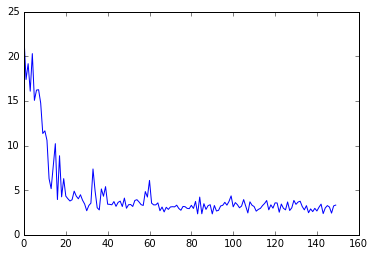

In [21]:
plt.plot(loss_trn)

In [25]:
trained_embeddings

array([[-0.05313754, -0.137252  ,  0.39693338,  0.21671011,  0.95107508,
         0.96374249,  0.09543069,  0.03570311, -0.55241251,  0.68524706],
       [ 0.08714867, -0.00770605, -0.05864093,  0.48591676,  1.49785566,
         0.68511641,  0.30349475,  0.30216429, -0.0173762 , -0.40650803],
       [-0.08708881, -0.46864259,  0.01007507, -0.90162992,  0.96119058,
         0.20717081,  0.07803373,  0.18517138, -0.07747902,  0.21749917],
       [ 0.46389961, -0.25993302,  0.64334762, -1.13073063,  0.08620727,
         0.280487  ,  0.9181754 ,  1.15655959,  0.2235125 , -0.22128654],
       [ 0.40049285, -0.01756494,  0.71382314, -0.75965542,  0.33816761,
         0.90955979,  0.82490927,  1.4305898 ,  0.60893607,  0.9079048 ],
       [ 0.54901886, -0.8656894 ,  0.13333333, -0.35177898,  0.00322838,
        -0.05957302,  0.15621777,  0.91231173, -1.07233906,  0.5243122 ],
       [-0.12708338, -0.63247073,  0.52955163, -0.30372912,  0.51897353,
         0.08946154, -0.09006827,  0.77304965

## Distributed Representations of charactors

In [27]:
# Dimension Reduction using tSNE
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
dim2_dataset = tsne.fit_transform(trained_embeddings)


labels = [' ','-','_','0','1','2','3','4','5','6','7','8','9','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']


In [28]:
dim2_dataset

array([[  24.64171559,   12.00420746],
       [ 102.48066573,  114.65719216],
       [ 317.13783488,  -25.16232612],
       [ -17.66334442,  103.58963179],
       [ -72.26254569, -122.30476777],
       [ 140.52386936,  -34.73340424],
       [ -15.11757101, -109.5040187 ],
       [-105.89217669,  -81.82083096],
       [-491.05191307,  241.43892683],
       [ 484.04455154,  -40.06489265],
       [-136.97263839,  -49.70682211],
       [ 101.73133034,    4.37040464],
       [ 289.5366074 ,  -85.02943566],
       [ -56.09512593,  -22.89594106],
       [-140.42656507,   60.45971019],
       [ 134.71235511,   38.46003523],
       [ -23.16896051,   26.12399814],
       [  36.14791945,  -29.78466553],
       [-150.2779054 ,    8.18684624],
       [  80.25793347,  -41.11211802],
       [ -51.7657639 ,  -67.66454067],
       [ -44.06660442,   70.84905065],
       [   1.24935448,  -62.52334683],
       [   9.35496065,   55.66133078],
       [  34.62924332,   92.79445966],
       [ -29.30106014,  1

In [29]:
# for key, value in idx_to_char.iteritems(): # idx_to_char dictionary는 공교롭게 key가 idx이다.
#     for char in labels:
#         if char==value: 
           
#             x, y = dim2_dataset[key,:]
#             plt.scatter(x, y)
#             plt.annotate(char, xy=(x, y), xytext=(10, 2), textcoords='offset points', ha='right', va='bottom')

In [30]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
    pylab.show()

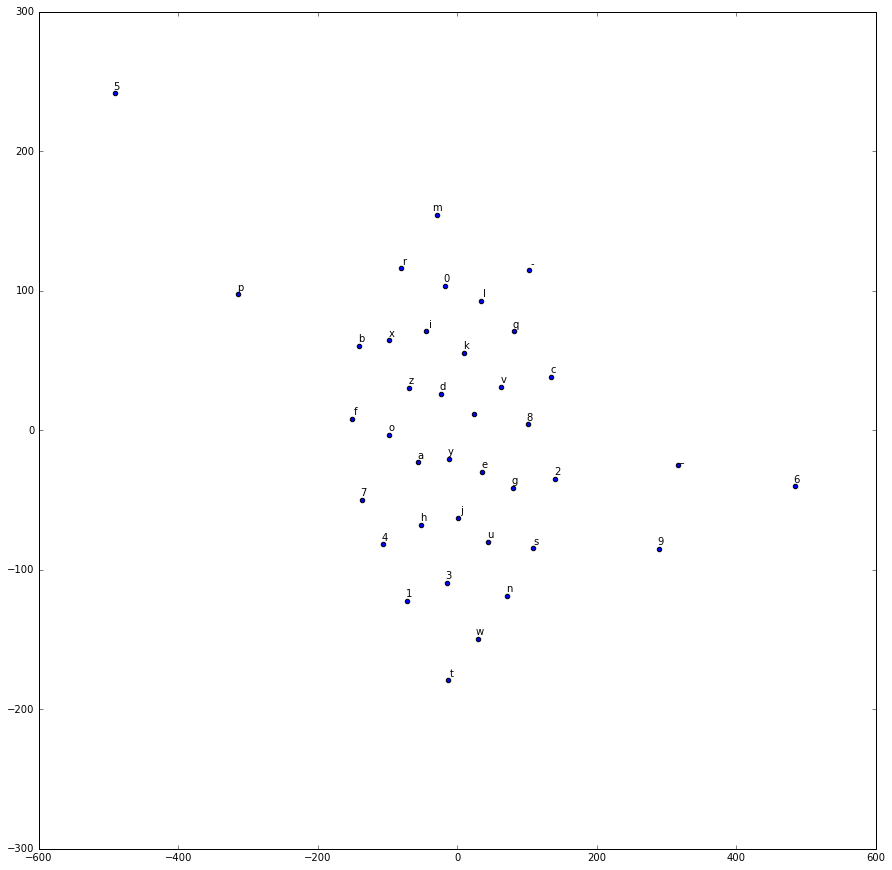

In [31]:
plot(dim2_dataset, labels)